In [1]:
cd /home/c01muya/vae-disentanglement/disentanglement_lib_pl

/home/c01muya/vae-disentanglement/disentanglement_lib_pl


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns

import torch
import torchvision.utils as vutils
import torchvision.transforms.functional as T
from torch.utils.data import DataLoader
from torchvision import transforms

from bvae_experiment import BVAEExperiment
from common.data_loader import DSpritesDataset, ThreeShapesDataset, ContinumDataset
from notebook_utils import *

# Change figure aesthetics
%matplotlib inline
sns.set_context('talk', font_scale=1.2, rc={'lines.linewidth': 1.5})
np.set_printoptions(suppress=True,precision=4)

In [73]:
def check_correlated_dimensions(image_batch, vae_model, current_device):
    
    with torch.no_grad():
        
        sq_diff_batch = []
        fwd_pass_results = vae_model.model.forward(image_batch, current_device=current_device)
        x_recon_orig, mu_orig = fwd_pass_results['x_recon'], fwd_pass_results['mu'] 

        # for each example X, perturb unit l=1 to L 
        for mu in mu_orig:
            # (dim(mu), mu)
            mus_perturbed = _generate_perturbed_copies(mu)
            
            # generate and image from these perturbed means
            # (dim(mu), X.shape)
            x_recons_perturbed = vae_model.model.decode(mus_perturbed, current_device=current_device)
            # pass images again and compare with mu_perturbed
            # (dim(mu), mu)
            mus_perturbed_recon, _ = vae_model.model.encode(x_recons_perturbed, current_device=current_device)

            sq_diff = (mus_perturbed_recon - mus_perturbed).pow(2)
            sq_diff_batch.append((sq_diff, mus_perturbed_recon, mus_perturbed, x_recons_perturbed))
    
    return sq_diff_batch

def _generate_perturbed_copies(vector, dims_to_perturb=None, limit=3, inter=2/3, mode = 'relative'):
    """
    Assumes that vector is of shape (vector_dim, )
    Returns (vector_dim, vector_dim) shaped vector where in (i, vector_dim) 
    """

    perturbed_copies = []

    for d in range(vector.shape[0]):
        if dims_to_perturb is not None and d not in dims_to_perturb:
                continue
        
        vector_d = vector.clone()
        
        if mode == 'relative':
            lim = vector_d[d] / 2
            min_val, max_val = vector_d[d] - lim, vector_d[d] + lim + 0.1
        
        vector_d[d] = vector_d[d] + 1.0 # 0.5 # * vector_d[d] # max_val

        perturbed_copies.append(vector_d)

    return torch.stack(perturbed_copies, dim=0)

def visualize_change(diff_entry):
    diff_np = diff_entry[0].cpu().numpy()
    fig, axs = plt.subplots(1,diff_np.shape[0])
    for r in range(diff_np.shape[0]):
        axs[r].imshow(np.expand_dims(diff_np[r,:], axis=1), cmap='Reds')
        axs[r].set_yticklabels([])
        axs[r].set_yticks([])
        axs[r].set_xticks([])
        axs[r].set_xticklabels([])
        


# Correlation 0.2 Beta 2

In [3]:
current_device = torch.device("cuda:3")
batch_size = 64
seed = 123
beta = 1.0
z_dim = 10

checkpoint_path="../train-logs/jscmodel/epoch=25-step=299520.ckpt"

acts_for_dsprites_full, dsprites_full_dataset, model_dsprites_full  = load_model_and_data_and_get_activations(
                    dset_name='dsprites_full', dset_path='../datasets', 
                    batch_size=batch_size, z_dim=z_dim , beta=beta, 
                    checkpoint_path=checkpoint_path, current_device=current_device, 
                    activation_with_label=False, seed=123,  batches=10, l_zero_reg=False
    )



Experiment class: cpu
Model class: cpu
Loaded 737280 images


  0%|▏                                                                                                                                                                                                   | 10/10368 [00:01<24:24,  7.07it/s]


In [4]:
dsprites_full_loader = DataLoader(dsprites_full_dataset, batch_size=batch_size, shuffle = False,drop_last=True)
img, labels = next(dsprites_full_loader.__iter__())


In [54]:
diffs = check_correlated_dimensions(img.to(current_device), model_dsprites_full, current_device)


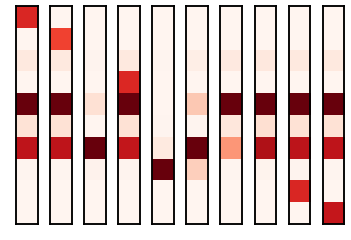

In [48]:
visualize_change(diffs[0])

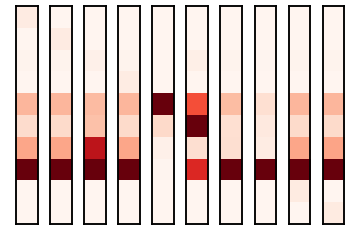

In [49]:
visualize_change(diffs[1])

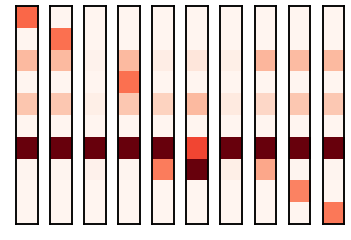

In [51]:
visualize_change(diffs[3])

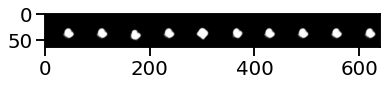

In [69]:
import torchvision.utils as vutils

recons_side_by_side = torch.cat(diffs[0][3].chunk(10, dim=0), dim = 3)
img_input_vs_recon = vutils.make_grid(recons_side_by_side, normalize=True, value_range=(0.0,1.0)).permute(1,2,0).cpu()

fig, axs = plt.subplots()
axs.imshow(img_input_vs_recon)

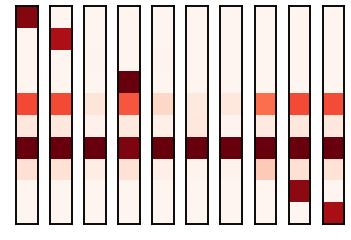

In [70]:
visualize_change(diffs[30])

# Correlation 0.2 Beta 1

In [34]:
current_device = torch.device("cuda:3")
batch_size = 64
seed = 123
beta = 1.0
z_dim = 10

checkpoint_path="../train-logs/jscmodel_bvae_w1corr02_dsprites/epoch=25-step=299520.ckpt"

acts_for_dsprites_full, dsprites_full_dataset, model_dsprites_full  = load_model_and_data_and_get_activations(
                    dset_name='dsprites_full', dset_path='../datasets', 
                    batch_size=batch_size, z_dim=z_dim , beta=beta, 
                    checkpoint_path=checkpoint_path, current_device=current_device, 
                    activation_with_label=False, seed=123,  batches=10, l_zero_reg=False
    )

dsprites_full_loader = DataLoader(dsprites_full_dataset, batch_size=batch_size, shuffle = False,drop_last=True)
img, labels = next(dsprites_full_loader.__iter__())



Experiment class: cpu
Model class: cpu
Loaded 737280 images


  0%|▏                                                                                                                                                                                                  | 10/10368 [00:00<01:01, 169.38it/s]


In [74]:
diffs = check_correlated_dimensions(img.to(current_device), model_dsprites_full, current_device)

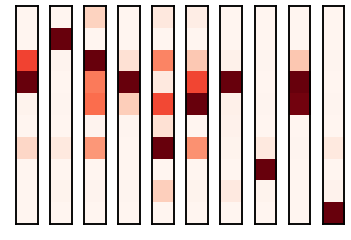

In [75]:
visualize_change(diffs[0])

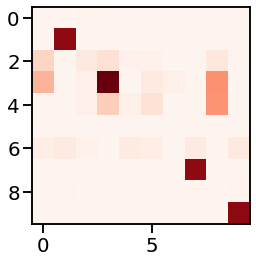

In [76]:
plt.imshow(diffs[0][0].cpu().numpy().T, cmap='Reds')

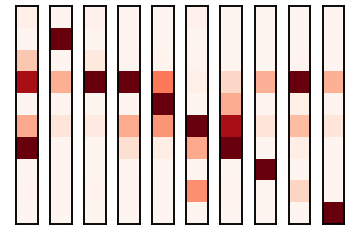

In [77]:
visualize_change(diffs[1])

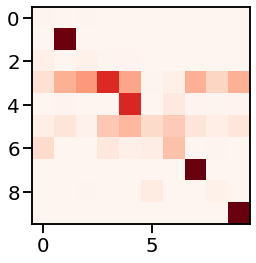

In [78]:
plt.imshow(diffs[1][0].cpu().numpy().T, cmap='Reds')

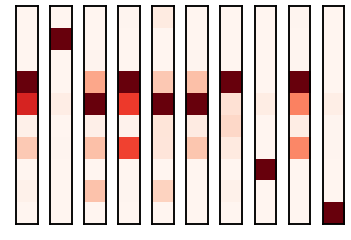

In [79]:
visualize_change(diffs[2])

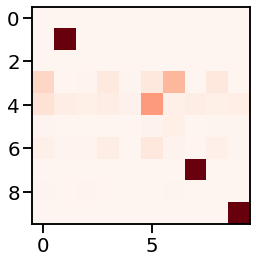

In [80]:
plt.imshow(diffs[2][0].cpu().numpy().T, cmap='Reds')

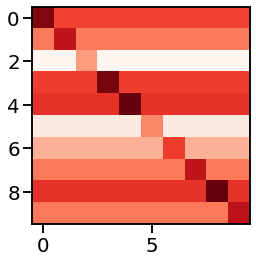

In [81]:
plt.imshow(diffs[2][2].cpu().numpy().T, cmap='Reds')